<a href="https://colab.research.google.com/github/yedini/DL_tensorflow/blob/main/Part4_Lab04_ManytoMany(Simple_pos_tagger_training).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Many to One: 마지막의 토큰까지 읽었을 때 출력 하나를 내는 구조
- Many to Many: sequence를 구성하는 각 token에 대해 모두 출력을 냄.
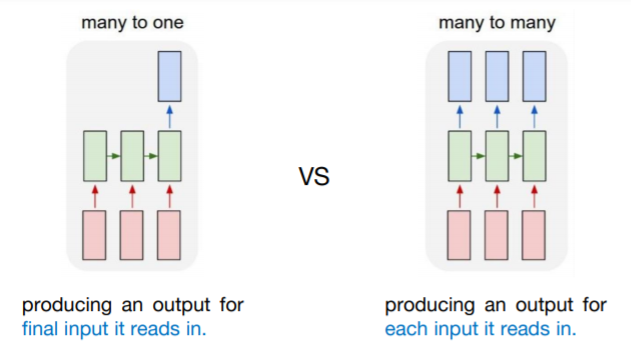

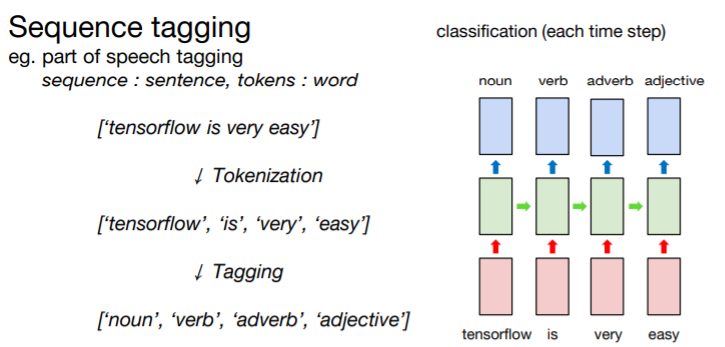

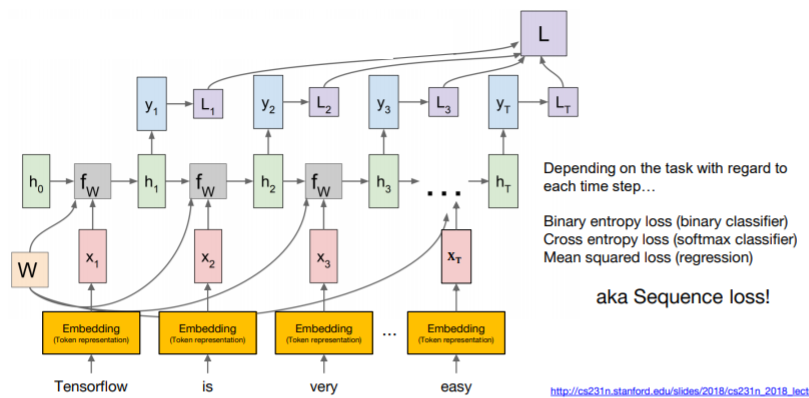
- x: token을 integer 타입으로 변환.
- x를 하나 넣을 때마다 y를 하나씩 출력
- 정답과 비교해서 토큰마다 loss를 계산함
- sequence loss: 각 token에서 계산된 loss의 평균. sequence loss를 이용하여 bacpropagation을 학습할 수 있음.
- sequence의 길이를 맞추는 pad를 처리하는 masking: pad 토큰에 대해서는 loss를 계산하지 않는 
방식.


In [ ]:
# setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pprint import pprint
%matplotlib inline

print(tf.__version__)

In [ ]:
# example data
sentences = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
pos = [['pronoun', 'verb', 'adjective'],
     ['noun', 'verb', 'adverb', 'adjective'],
     ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
     ['noun', 'verb', 'adverb', 'adjective', 'verb']]

In [ ]:
# creating a token dictionary for word (token인 word를 integer index로 mapping하는 token dictionary)
word_list = sum(sentences, [])
word_list = sorted(set(word_list))
word_list = ['<pad>'] + word_list
word2idx = {word : idx for idx, word in enumerate(word_list)}
idx2word = {idx : word for idx, word in enumerate(word_list)}

print(word2idx)
print(idx2word)
print(len(idx2word))

In [ ]:
# creating a token dictionary for part of speech (품사를 integer index로 mapping하는 dictionary)
pos_list = sum(pos, [])
pos_list = sorted(set(pos_list))
pos_list = ['<pad>'] + pos_list
pos2idx = {pos : idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx : pos for idx, pos in enumerate(pos_list)}

print(pos2idx)
print(idx2pos)
print(len(pos2idx))

In [ ]:
# converting sequence of tokens to sequence of indices
max_sequence = 10
x_data = list(map(lambda sentence : [word2idx.get(token) for token in sentence], sentences))
y_data = list(map(lambda sentence : [pos2idx.get(token) for token in sentence], pos))

# padding the sequence of indices
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence, padding='post')

#loss function에서 활용
x_data_mask = ((x_data != 0) * 1).astype(np.float32) # padding한 부분에 대한 masking number를 담음
x_data_len = list(map(lambda sentence : len(sentence), sentences)) # 각 setence가 몇개의 word로 tokenization 됐는지

y_data = pad_sequences(sequences = y_data, maxlen = max_sequence, padding='post')

# checking data
print(x_data, x_data_len)
print(x_data_mask)
print(y_data)

In [ ]:
# creating rnn for "many to many" sequence tagging
num_classes = len(pos2idx)
hidden_dim = 10

input_dim = len(word2idx)
output_dim = len(word2idx)
one_hot = np.eye(len(word2idx))

model = Sequential()
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True,
                           trainable=False, input_length=max_sequence,
                           embeddings_initializer=keras.initializers.Constant(one_hot))) #token을 onehot vector로 표현
model.add(layers.SimpleRNN(units=hidden_dim, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(units=num_classes))) #매 token마다 품사가 무엇인지 classification

model.summary()

In [ ]:
# creating loss function
def loss_fn(model, x, y, x_len, max_sequence):
    masking = tf.sequence_mask(x_len, maxlen=max_sequence, dtype=tf.float32) #masking 생성 => pad를 0으로 가짐.
    valid_time_step = tf.cast(x_len,dtype=tf.float32)    
    sequence_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True) * masking    # masking을 loss에 반영 => pad는 0으로 계산됨
    sequence_loss = tf.reduce_sum(sequence_loss, axis=-1) / valid_time_step    
    sequence_loss = tf.reduce_mean(sequence_loss)    
    return sequence_loss

# creating and optimizer
lr = 0.1
epochs = 30
batch_size = 2 
opt = tf.keras.optimizers.Adam(learning_rate = lr)

In [ ]:
# generating data pipeline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, x_data_len))
tr_dataset = tr_dataset.shuffle(buffer_size=4)
tr_dataset = tr_dataset.batch(batch_size = 2)

print(tr_dataset)

In [ ]:
# training
tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb, x_mb_len in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb, x_len=x_mb_len, max_sequence=max_sequence)
        grads = tape.gradient(target=tr_loss, sources=model.variables)
        opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    else:
        avg_tr_loss /= tr_step
        tr_loss_hist.append(avg_tr_loss)
    
    if (epoch + 1) % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss))

In [ ]:
# checking performance
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1) * x_data_mask

pprint(list(map(lambda row : [idx2pos.get(elm) for elm in row],yhat.astype(np.int32).tolist())), width = 120)
pprint(pos)

In [ ]:
plt.plot(tr_loss_hist)

## Many to Many bidirectional

#### 위의 RNN과의 차이점
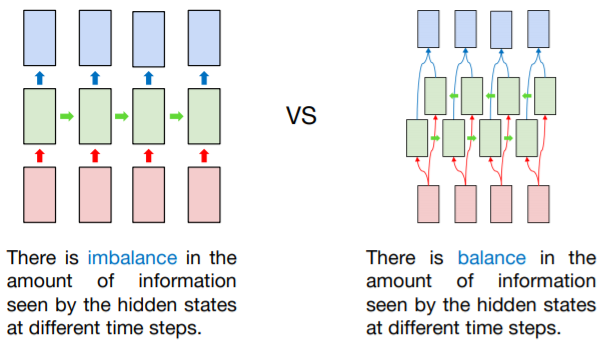
sequence를 순서대로 읽는 forward RNN과 역으로 읽는 backward RNN을 둬서 양방향으로 hidden state에 input token을 넣을 수 있다.

In [ ]:
# creating bidirectional rnn for "many to many" sequence tagging
num_classes = len(pos2idx)
hidden_dim = 10

input_dim = len(word2idx)
output_dim = len(word2idx)
one_hot = np.eye(len(word2idx))

model = Sequential()
model.add(layers.InputLayer(input_shape=(max_sequence,)))
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True,
                                 trainable=False, input_length=max_sequence,
                                 embeddings_initializer=keras.initializers.Constant(one_hot)))
model.add(layers.Bidirectional(keras.layers.SimpleRNN(units=hidden_dim, return_sequences=True)))
model.add(layers.TimeDistributed(keras.layers.Dense(units=num_classes)))

In [ ]:
model.summary()

Bidirectional 코드가 추가됨! 다른 코드는 위의 예제와 동일하게 진행된다.